In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
import matplotlib.pyplot as plt
import numpy as np
import os

In [2]:
import cv2

PATHS = [os.getcwd() + "\\images\\without_mask", os.getcwd() + "\\images\\with_mask"]
X, y = [], []

for PATH in PATHS:
    is_mask = PATHS.index(PATH)
    for img in os.listdir(PATH):
        img = load_img(os.path.join(PATH, img), target_size=(224, 224))
        img = img_to_array(img)
        img = preprocess_input(img)
        X.append(img)
        y.append(is_mask)
#         break

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


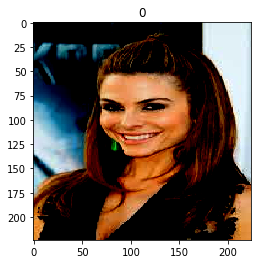

In [3]:
plt.imshow(X[122])
plt.title(y[122])
plt.show()

In [4]:
X = np.array(X, dtype="float32")
y = np.array(y)

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

trainX, testX, trainY, testY = train_test_split(X, y, test_size=0.2, random_state=42)

aug = ImageDataGenerator(
        rotation_range=20,
        zoom_range=0.15,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.15,
        horizontal_flip=True,
        fill_mode="nearest")
        

In [27]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Input

baseModel = MobileNetV2(weights="imagenet", include_top=False, input_tensor=Input(shape=(224, 224, 3)))

9412608/9406464 [==============================] - 8s 1us/step


In [28]:
from tensorflow.keras.models import Model

headModel = baseModel.output
headModel = keras.layers.AveragePooling2D(pool_size=(7,7))(headModel)
headModel = keras.layers.Flatten(name="flatten")(headModel)
headModel = keras.layers.Dense(128, activation="relu")(headModel)
headModel = keras.layers.Dropout(0.5)(headModel)
headModel = keras.layers.Dense(2, activation="softmax")(headModel)

model = Model(inputs=baseModel.input, outputs=headModel)

for layer in baseModel.layers:
    layer.trainable = False

In [32]:
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=['accuracy'])

H = model.fit(
    aug.flow(trainX, trainY, batch_size=32),
    steps_per_epoch=len(trainX) // 32,
    validation_data=(testX, testY),
    validation_steps=len(testX) // 32,
    epochs=20)

Epoch 1/20
32/32 [==============================] - 51s 2s/step - loss: 0.7260 - accuracy: 0.5039 - val_loss: 0.6934 - val_accuracy: 0.4583
Epoch 2/20
32/32 [==============================] - 52s 2s/step - loss: 0.6933 - accuracy: 0.4618 - val_loss: 0.6932 - val_accuracy: 0.4015
Epoch 3/20
32/32 [==============================] - 57s 2s/step - loss: 0.6933 - accuracy: 0.4795 - val_loss: 0.6932 - val_accuracy: 0.4091
Epoch 4/20
32/32 [==============================] - 51s 2s/step - loss: 0.6932 - accuracy: 0.4706 - val_loss: 0.6932 - val_accuracy: 0.4318
Epoch 5/20
32/32 [==============================] - 51s 2s/step - loss: 0.6932 - accuracy: 0.4745 - val_loss: 0.6932 - val_accuracy: 0.4545
Epoch 6/20
32/32 [==============================] - 45s 1s/step - loss: 0.6932 - accuracy: 0.4843 - val_loss: 0.6932 - val_accuracy: 0.4583
Epoch 7/20
32/32 [==============================] - 45s 1s/step - loss: 0.6932 - accuracy: 0.4843 - val_loss: 0.6932 - val_accuracy: 0.4621
Epoch 8/20
32/32 [==

In [33]:
model.save("models\MobileNetV2.h5")